In [1]:
from example.discretizer.utils import IsTrafficLightNearby, IsStopSignNearby, IsZebraNearby, LanePosition, FrontLeftObjects, FrontRightObjects, PedestrianNearby
from pgeon.intention_introspector import IntentionIntrospector
from pgeon.desire import Desire
from pgeon.discretizer import Predicate
from example.discretizer.discretizer_d0 import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
import numpy as np
import matplotlib.pyplot as plt

### Define Desires

In [2]:
#NOTE: traffic light color can be also green or yellow
stop_traffic_light = Desire("stop_traffic_light", 1, {Predicate(IsTrafficLightNearby, [IsTrafficLightNearby.YES])})
stop_stop_sign = Desire("stop_stop_sign", 1, {Predicate(IsStopSignNearby, [IsStopSignNearby.YES])})
stop_zebra = Desire("stop_zebra", 1, {Predicate(IsZebraNearby, [IsZebraNearby.YES])})
#obstacle_avoidance_l = Desire("obstacle_avoidance_left", 7, {Predicate(FrontLeftObjects, [FrontLeftObjects(1, discretization="binary")]) })
#obstacle_avoidance_r = Desire("obstacle_avoidance_right", 8, {Predicate(FrontRightObjects, [FrontRightObjects(1,discretization="binary")])})
lane_change = Desire("lane_change", 8, {Predicate(LanePosition, [LanePosition.CENTER]) })
any = Desire("any", None, set())


#### Example with Discretiser D0a

In [3]:
environment = SelfDrivingEnvironment(city='all')
discretizer_configs = {
    'a': {'obj_discretizer': 'binary', 'vel_discretizer': 'binary' },
    'b': {'obj_discretizer': 'multiple', 'vel_discretizer': 'binary'},
    'c': {'obj_discretizer': 'multiple', 'vel_discretizer': 'multiple'}
    }

default_config = {'obj_discretizer': 'multiple', 'vel_discretizer': 'multiple'}
intentions_data = {}
desires_data = {}
commitment_threshold = 0.5
for discretizer_id in ['0a','0b','0c','1a','1b','1c']:
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1
    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
        ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    print(f'DISCRETIZER {discretizer_id} ')
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    #if '0' not in discretizer_id: 
    #    stop_zebra = Desire("stop_zebra", 1, {Predicate(IsZebraNearby, [IsZebraNearby.YES]), Predicate(PedestrianNearby, [PedestrianNearby())})
    ii = IntentionIntrospector({stop_traffic_light, stop_stop_sign, stop_zebra,lane_change}, pg)

    desires_data[discretizer_id] = ii.find_desires() 
    
    intentions_data[discretizer_id] = ii.find_intentions( commitment_threshold) #{desire.name: [self.get_intention_metrics(commitment_threshold, desire)] for desire in self.desires}
    intentions_data[discretizer_id]['any']=ii.get_intention_metrics(commitment_threshold,any)
    print(intentions_data[discretizer_id])
    print()

DISCRETIZER 0a 
{'stop_zebra': (0.12392398895566022, 0.971085239392309), 'stop_traffic_light': (0.11239239889556603, 0.9788627830033394), 'lane_change': (0.002003140057387256, 0.7297297297297295), 'stop_stop_sign': (0.011585728980564128, 0.9010345168410996), 'any': (0.14292675004060418, 0.9634332142494575)}

DISCRETIZER 0b 
{'stop_zebra': (0.12344457437558093, 0.9706070519876191), 'stop_traffic_light': (0.12629306467572188, 0.9777726064802724), 'lane_change': (0.0011094120116338338, 0.8108108108108111), 'stop_stop_sign': (0.010284549188929869, 0.8699775148154498), 'any': (0.14947078048634224, 0.965786990451784)}

DISCRETIZER 0c 
{'stop_zebra': (0.12344457437558094, 0.9706070519876191), 'stop_traffic_light': (0.12629306467572188, 0.9777726064802723), 'lane_change': (0.00197895115588738, 0.8030303030303028), 'stop_stop_sign': (0.010284549188929869, 0.8699775148154498), 'any': (0.1503403196305958, 0.9647882224575473)}

DISCRETIZER 1a 
{'stop_zebra': (0.12308476507451052, 0.971781999060925

### Bar Plot

#### Desires

In [6]:
desires_data

{'0a': [(0.22083265659682744, 29.478008905546304),
  (0.07341237615721945, 18.053946346566484),
  (0.34199556060852143, 37.95983281341127),
  (0.060364896323967306, 12.564735032460554)],
 '0b': [(0.24302119876465475, 83.44421672602695),
  (0.06797397379388924, 40.52233390413697),
  (0.34715600731612245, 103.36085739034728),
  (0.05663998081017061, 24.368006704850025)],
 '0c': [(0.24302119876465475, 83.51576818204569),
  (0.06797397379388924, 40.77187582467234),
  (0.34715600731612245, 103.5772657957448),
  (0.05663998081017061, 35.33586536294447)],
 '1a': [(0.24302119876465472, 107.63762934356939),
  (0.06797397379388923, 37.23048612224236),
  (0.34715600731612245, 120.25948021375982),
  (0.056639980810170604, 33.818032139858765)],
 '1b': [(0.24302119876465475, 214.66231269204388),
  (0.06797397379388924, 52.000270428496236),
  (0.34715600731612245, 226.29959271033186),
  (0.056639980810170604, 51.51340278079408)],
 '1c': [(0.24302119876465472, 214.7080436528679),
  (0.0679739737938892

TypeError: list indices must be integers or slices, not str

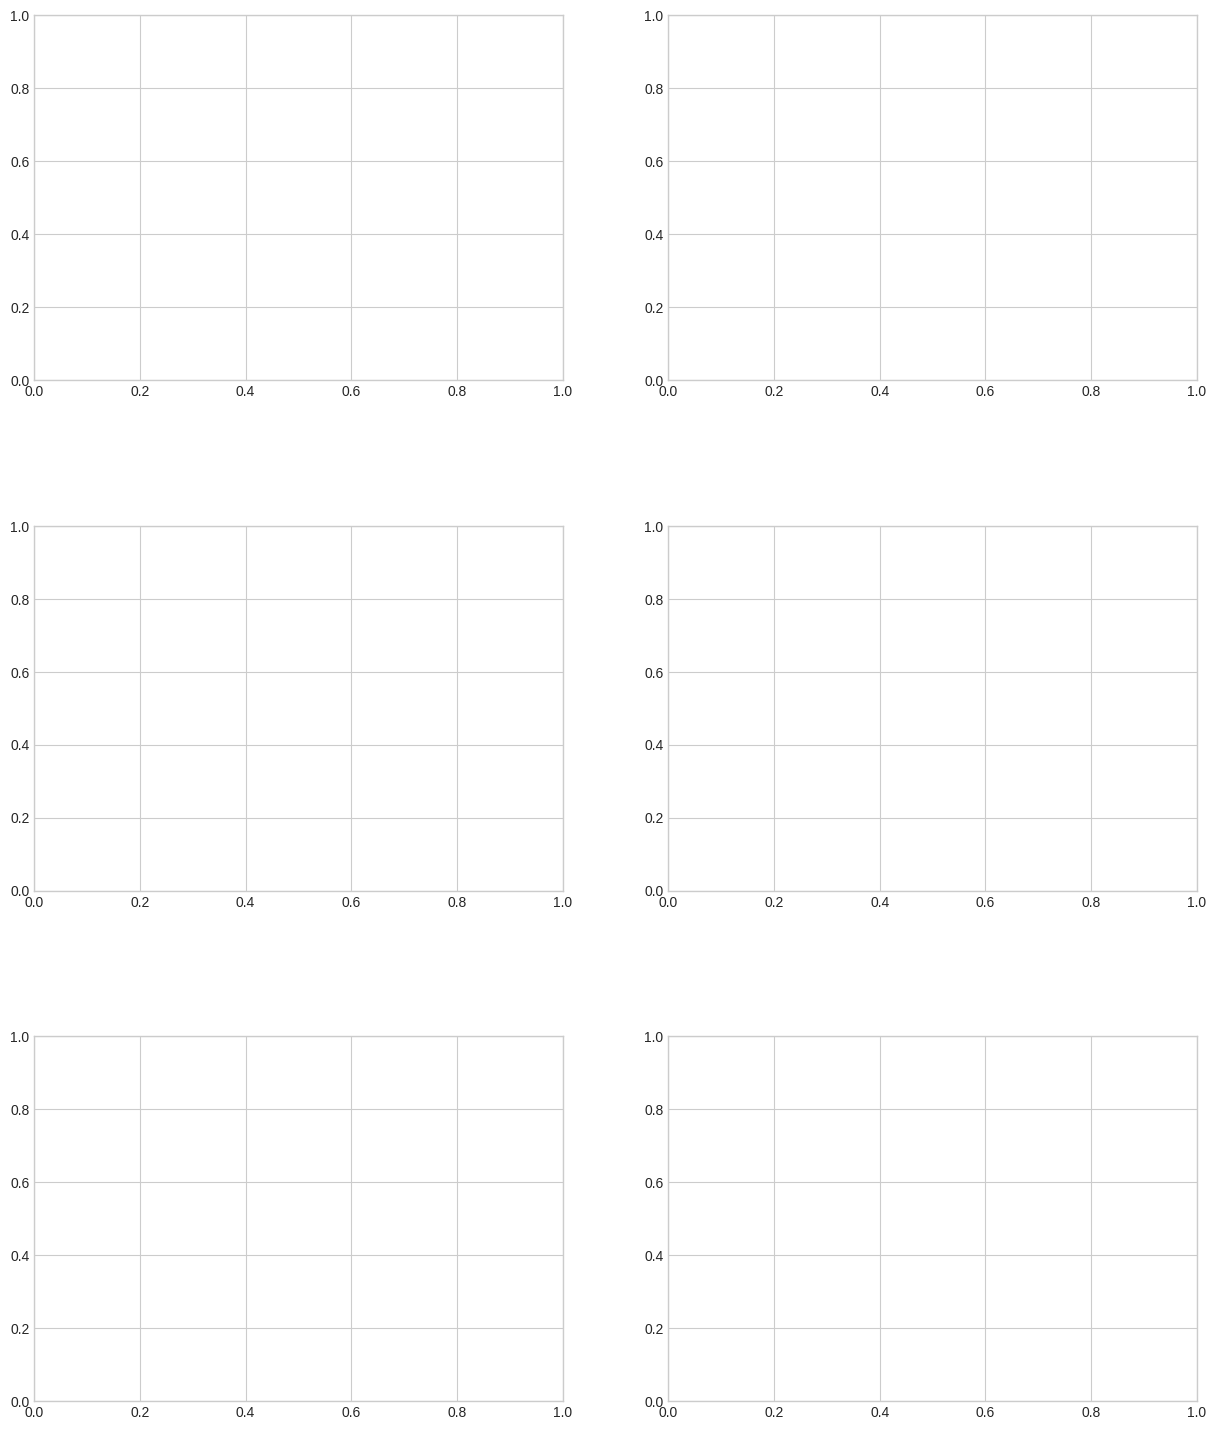

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.subplots_adjust(hspace=0.4)
discretizer_labels = list(desires_data.keys())
desires = ["stop_zebra", "stop_stop_sign", "stop_traffic_light", "lane_change"]#, "any"]

for i, discretizer in enumerate(discretizer_labels):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    values = desires_data[discretizer]
    labels = []
    val1 = []
    val2 = []

    for desire in desires:
        print(values[desire])
        if desire == 'any':
            #value = ii.get_intention_metrics(0.5,Desire("any", None, set()))
            val1.append(values[desire][0])
            val2.append(values[desire][1])
        else:
            val1.append(values[desire][0])
            val2.append(values[desire][1])
        labels.append(f"{desire}")

    x = np.arange(len(desires))
    width = 0.35

    rects1 = ax.bar(x - width/2, val1, width, label='Desire Probability')
    rects2 = ax.bar(x + width/2, val2, width, label='Expected Action Prob.')

    ax.set_xlabel('Desires')
    ax.set_ylabel('Desires Metrics')
    ax.set_title(f'Discretizer {discretizer}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    ax.legend()
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    for rect in rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')


plt.show()

#### Intentions

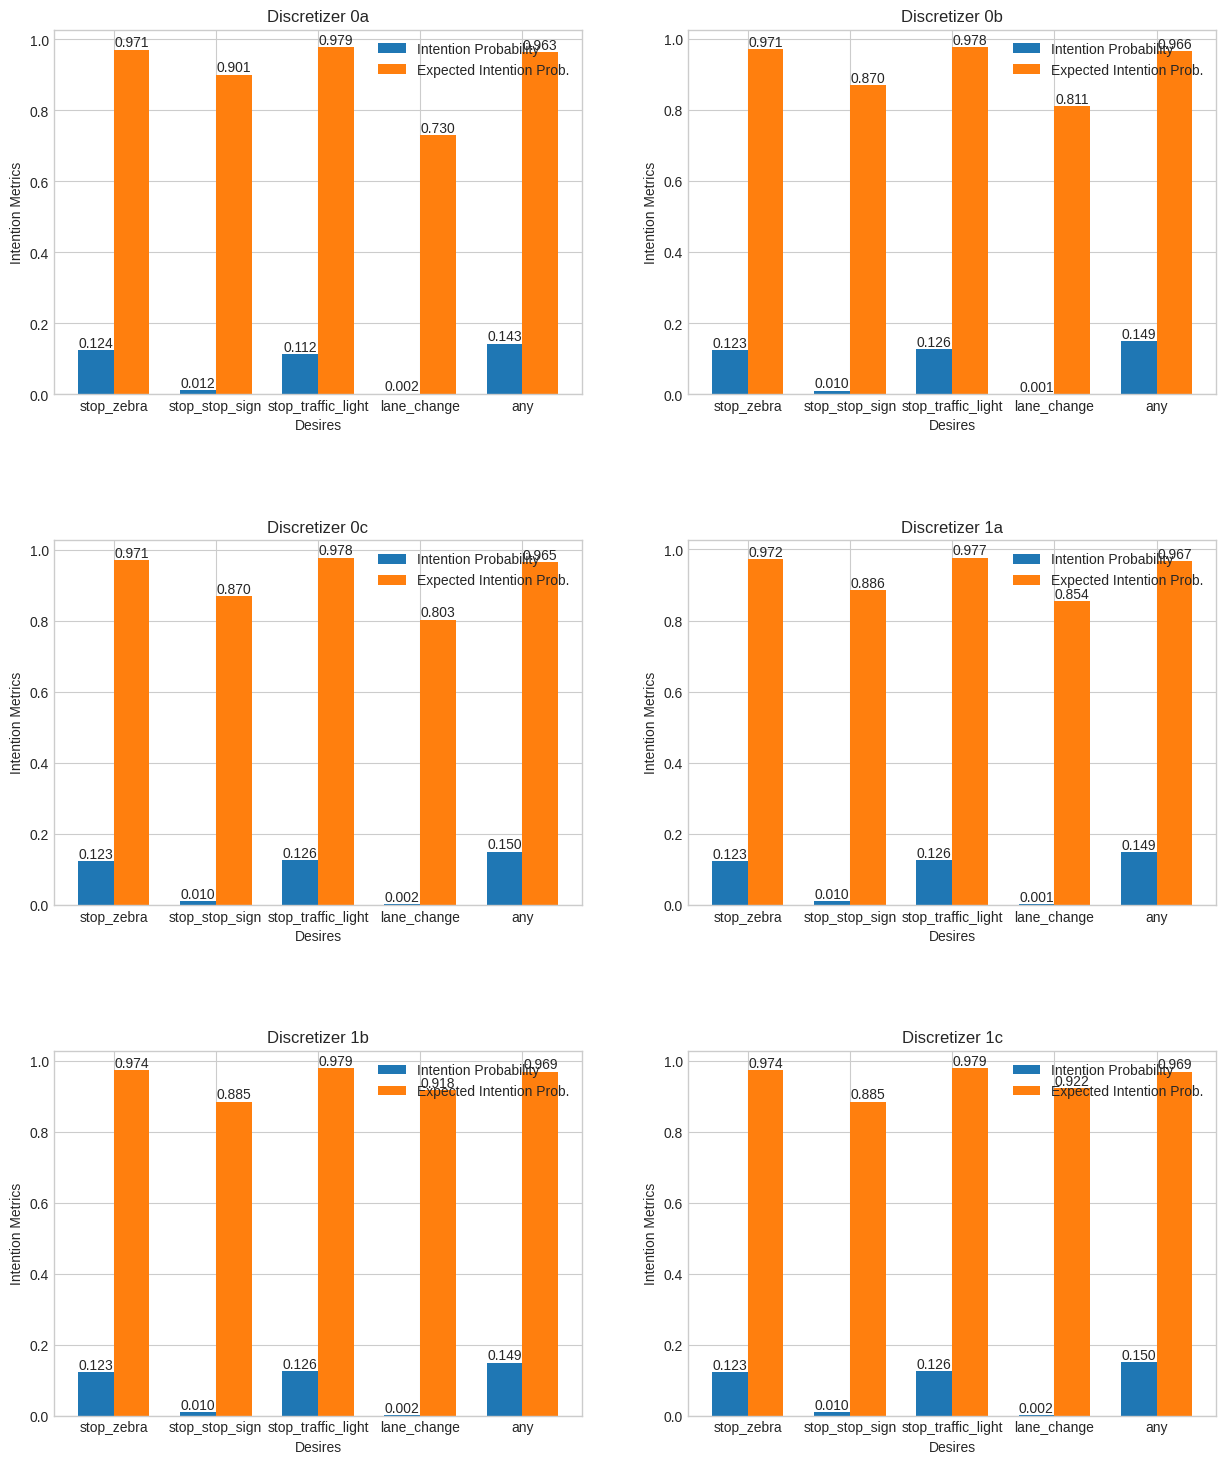

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.subplots_adjust(hspace=0.4)
discretizer_labels = list(discretised_data.keys())
desires = ["stop_zebra", "stop_stop_sign", "stop_traffic_light", "lane_change", "any"]

for i, discretizer in enumerate(discretizer_labels):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    values = discretised_data[discretizer]
    labels = []
    val1 = []
    val2 = []

    for desire in desires:
        if desire == 'any':
            #value = ii.get_intention_metrics(0.5,Desire("any", None, set()))
            val1.append(values[desire][0])
            val2.append(values[desire][1])
        else:
            val1.append(values[desire][0])
            val2.append(values[desire][1])
        labels.append(f"{desire}")

    x = np.arange(len(desires))
    width = 0.35

    rects1 = ax.bar(x - width/2, val1, width, label='Intention Probability')
    rects2 = ax.bar(x + width/2, val2, width, label='Expected Intention Prob.')

    ax.set_xlabel('Desires')
    ax.set_ylabel('Intention Metrics')
    ax.set_title(f'Discretizer {discretizer}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    ax.legend()
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

    for rect in rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')


plt.show()

In [43]:
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [42]:
intention_probabilities, expected_probabilities

([0.16479265989025815,
  0.15870588588048334,
  0.15504782465293396,
  0.15396839674972265,
  0.1526790800875536,
  0.1498905580042577,
  0.14896105064315912,
  0.14668225840304638,
  0.14398368864501815,
  0.13588797937093341],
 [0.8998052895797938,
  0.9325838439630405,
  0.9506588207864726,
  0.955570937154206,
  0.960694572326561,
  0.9693652255024703,
  0.9716700407179646,
  0.9764084414595627,
  0.9805477083757144,
  0.9871716737521499])

### ROC Curve

Choose the discretiser with higher AIC, that is, the discretiser where the interpretability vs reliability trade-off is better

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


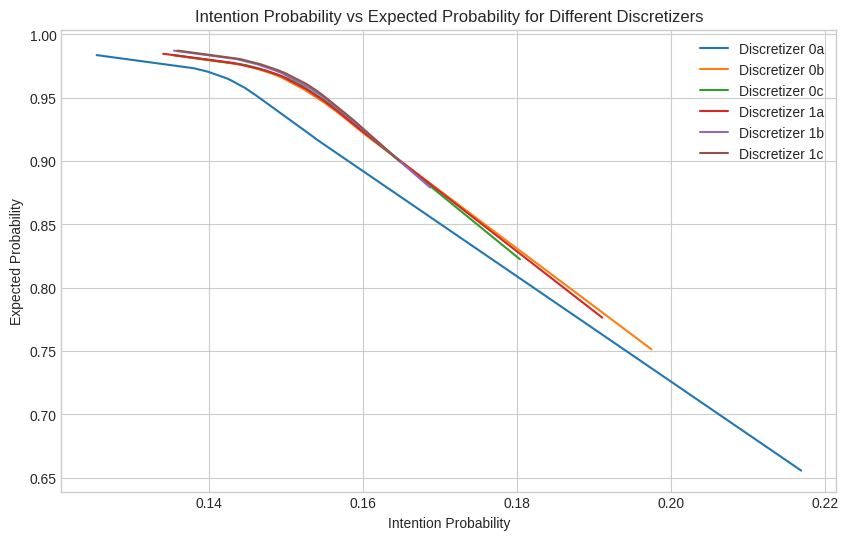

In [41]:
plt.figure(figsize=(10, 6))

thresholds = np.arange(0, 1, 0.1)
for discretizer_id in ['0a','0b','0c','1a','1b','1c']:
    intention_probabilities=[]
    expected_probabilities=[]
    config = default_config
    for key in discretizer_configs:
        if key in discretizer_id:
            config = discretizer_configs[key]
            break

    DiscretizerClass = AVDiscretizer if '0' in discretizer_id else AVDiscretizerD1
    discretizer = DiscretizerClass(
            environment,
            vel_discretization=config['vel_discretizer'],
            obj_discretization=config['obj_discretizer'],
            id=discretizer_id
            ) 
    nodes_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_nodes.csv'
    edges_path = f'example/dataset/data/policy_graphs/PG_trainval_Call_D{discretizer_id}_Wall_Tall_edges.csv'
    pg = PG.PolicyGraph.from_nodes_and_edges(nodes_path, edges_path, environment, discretizer)
    #NOTE: register desires 
    ii = IntentionIntrospector({stop_traffic_light, stop_stop_sign, stop_zebra,lane_change}, pg)
    for threshold in thresholds:
        print(threshold)
        ii.intention = {}
        ii.find_intentions( commitment_threshold=threshold) 
        intention_prob, expected_prob=ii.get_intention_metrics(commitment_threshold=threshold,desire=any)
        intention_probabilities.append(intention_prob)
        expected_probabilities.append(expected_prob)
       
    plt.plot(intention_probabilities, expected_probabilities, label=f'Discretizer {discretizer_id}')

plt.xlabel('Intention Probability for ANY desire')
plt.ylabel('Expected Probability')
plt.title('Intention Probability vs Expected Probability for Different Discretizers')
plt.legend()
plt.grid(True)
plt.show()
        
